In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from keras.optimizers import Adam
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, LeakyReLU, Reshape
from keras.callbacks import EarlyStopping
from keras.utils import get_file
import matplotlib.pyplot as plt
import seaborn as sns
from zipfile import ZipFile
from keras.utils.vis_utils import plot_model
import os
%matplotlib inline

Using TensorFlow backend.


In [2]:
try:
    path = get_file('NSL-KDD.zip', origin=\
                  'http://205.174.165.80/CICDataset/NSL-KDD/Dataset/NSL-KDD.zip')
    print(path)
except:
    print("Error downloading")

/Users/xuwen/.keras/datasets/NSL-KDD.zip


In [3]:
filespath = os.path.dirname(path)+"/NSL-KDD/"
with ZipFile(path, 'r') as zipObj:
    zipObj.extractall(filespath)
    print(zipObj.namelist())

['index.html', 'KDDTest1.jpg', 'KDDTest-21.arff', 'KDDTest-21.txt', 'KDDTest+.arff', 'KDDTest+.txt', 'KDDTrain1.jpg', 'KDDTrain+.arff', 'KDDTrain+.txt', 'KDDTrain+_20Percent.arff', 'KDDTrain+_20Percent.txt']


In [4]:
df_train = pd.read_csv(filepath_or_buffer=filespath+'KDDTrain+.txt',delimiter=',', header=None)
df_test = pd.read_csv(filepath_or_buffer=filespath+'KDDTest+.txt',delimiter=',', header=None)

## Data mining and exploration

In [5]:
# The CSV file has no column heads, so add them
df_train.columns = [
    'duration',
    'protocol_type',
    'service',
    'flag',
    'src_bytes',
    'dst_bytes',
    'land',
    'wrong_fragment',
    'urgent',
    'hot',
    'num_failed_logins',
    'logged_in',
    'num_compromised',
    'root_shell',
    'su_attempted',
    'num_root',
    'num_file_creations',
    'num_shells',
    'num_access_files',
    'num_outbound_cmds',
    'is_host_login',
    'is_guest_login',
    'count',
    'srv_count',
    'serror_rate',
    'srv_serror_rate',
    'rerror_rate',
    'srv_rerror_rate',
    'same_srv_rate',
    'diff_srv_rate',
    'srv_diff_host_rate',
    'dst_host_count',
    'dst_host_srv_count',
    'dst_host_same_srv_rate',
    'dst_host_diff_srv_rate',
    'dst_host_same_src_port_rate',
    'dst_host_srv_diff_host_rate',
    'dst_host_serror_rate',
    'dst_host_srv_serror_rate',
    'dst_host_rerror_rate',
    'dst_host_srv_rerror_rate',
    'outcome',
    'difficulty'
]
df_test.columns = df_train.columns

In [6]:
print(f"df_train.shape = {df_train.shape}")
print(f"df_test.shape = {df_test.shape}")

df_train.shape = (125973, 43)
df_test.shape = (22544, 43)


In [7]:
df_obj_col = df_train.select_dtypes(include='object').columns
print(df_obj_col)

Index(['protocol_type', 'service', 'flag', 'outcome'], dtype='object')


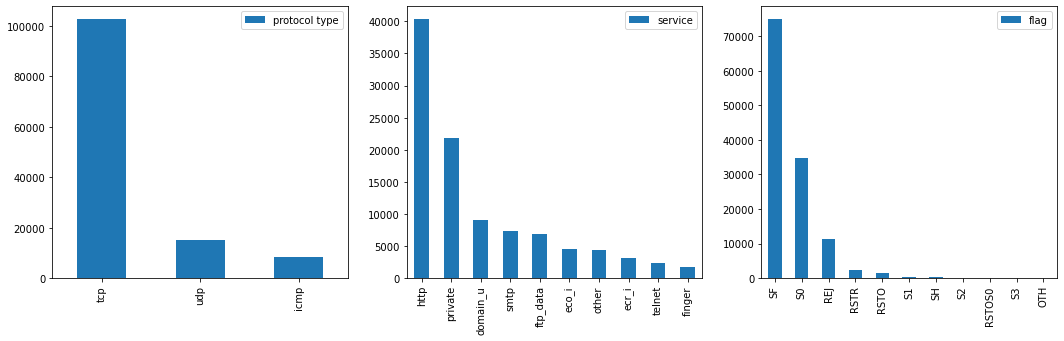

In [8]:
plt.figure(figsize=(18, 5))
plt.subplot(131)
df_train["protocol_type"].value_counts().plot(kind='bar', label='protocol type')
plt.legend()
plt.subplot(132)
df_train['service'].value_counts().head(10).plot(kind='bar')
plt.legend()
plt.subplot(133)
df_train["flag"].value_counts().plot(kind='bar')
plt.legend()
plt.show()

In [9]:
df_train['label'] = np.where(df_train['outcome'].str.contains('normal'), 0, 1)
df_test['label'] = np.where(df_test['outcome'].str.contains('normal'), 0, 1)

In [10]:
df_train_obj = df_train.iloc[:, :-3].select_dtypes(include='object')
df_train_num = df_train.iloc[:, :-3].select_dtypes(exclude='object')

print(f"shape of numeric features: {df_train_num.shape}")
print(f"shape of object features: {df_train_obj.shape}")

shape of numeric features: (125973, 38)
shape of object features: (125973, 3)


In [11]:
df_test_obj = df_test.iloc[:, :-3].select_dtypes(include='object')
df_test_num = df_test.iloc[:, :-3].select_dtypes(exclude='object')

print(f"shape of numeric features: {df_test_num.shape}")
print(f"shape of object features: {df_test_obj.shape}")

shape of numeric features: (22544, 38)
shape of object features: (22544, 3)


# Data Preprocessing

In [12]:
enc = OneHotEncoder(handle_unknown='ignore')
X_train_enc = enc.fit_transform(df_train_obj)
# X_train = np.c_[df_train_num, X_train_enc.toarray()]
X_train = np.c_[df_train_num, X_train_enc.toarray()][df_train.outcome == 'normal']
X_test_enc = enc.transform(df_test_obj)
X_test = np.c_[df_test_num, X_test_enc.toarray()]
# X_test_enc = enc.transform(df_test_obj)
X_test_normal = np.c_[df_test_num, X_test_enc.toarray()][df_test.outcome == 'normal']
X_test_abnormal = np.c_[df_test_num, X_test_enc.toarray()][df_test.outcome != 'normal']


# scaler = MinMaxScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

In [13]:
print(f"shape of X_train: {X_train.shape}")
print(f"shape of X_test: {X_test.shape}")
print(f"shape of X_test_normal: {X_test_normal.shape}")
print(f"shape of X_test_abnormal: {X_test_abnormal.shape}")

shape of X_train: (67343, 122)
shape of X_test: (22544, 122)
shape of X_test_normal: (9711, 122)
shape of X_test_abnormal: (12833, 122)


In [14]:
outlier_fence_95 = np.percentile(X_train, 95, axis=0)
X_train_new = X_train.copy()
for index, fence in enumerate(outlier_fence_95):
    boolarr = X_train_new[:,index] <= fence
    X_train_new = X_train_new[boolarr]
X_train_new.shape

(39252, 122)

In [15]:
# # y_train = df_train['label']
# y_train = np.zeros((X_train.shape[0],1))
# y_test = df_test['label']

In [16]:
# from sklearn.preprocessing import RobustScaler, MinMaxScaler
# # scaler = RobustScaler()
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_new)
X_test_scaled = scaler.transform(X_test)
X_test_normal_scaled = scaler.transform(X_test_normal)
X_test_abnormal_scaled = scaler.transform(X_test_abnormal)
y_train = np.zeros((X_train_scaled.shape[0],1))
y_test = df_test['label']

# Model Establishing

In [30]:
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply, GaussianNoise
from keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D
from keras.layers import MaxPooling2D, concatenate
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
# from keras.optimizers import Adam
from tensorflow.keras.optimizers import Adam
from keras import losses
from keras.utils import to_categorical
from keras.initializers import RandomNormal
from keras.utils.vis_utils import plot_model
import keras.backend as K

import matplotlib.pyplot as plt

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             (None, 32)                3936      
_________________________________________________________________
dense_31 (Dense)             (None, 10)                330       
Total params: 4,266
Trainable params: 4,266
Non-trainable params: 0
_________________________________________________________________


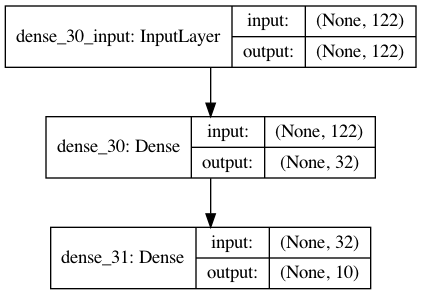

In [61]:
optimizer = Adam(0.001, 0.5)
instance_shape = 122
latent_dim = 10
initializer = RandomNormal(mean=0., stddev=1.)
encoder = Sequential()
encoder.add(Dense(32, activation='relu', input_shape=(instance_shape,), kernel_initializer=initializer))
encoder.add(Dense(latent_dim, activation='relu'))
# encoder.add(Dense(latent_dim, activation='relu', input_shape=(instance_shape,), kernel_initializer=initializer))
encoder.summary()
# img = Input(shape=(instance_shape,))
# z = model(img)
# encoder = Model(img, z)
# plot_model(encoder, to_file='e_model_plot.png', show_shapes=True, show_layer_names=True)
plot_model(encoder, to_file='e_model_plot.png', show_shapes=True, show_layer_names=True)              

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_32 (Dense)             (None, 32)                352       
_________________________________________________________________
dense_33 (Dense)             (None, 122)               4026      
Total params: 4,378
Trainable params: 4,378
Non-trainable params: 0
_________________________________________________________________


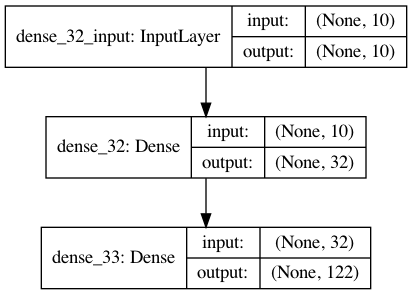

In [62]:
generator = Sequential()
generator.add(Dense(32, activation='relu', input_dim=latent_dim, kernel_initializer=initializer))
generator.add(Dense(instance_shape, activation='sigmoid'))
# generator.add(Dense(instance_shape, activation='relu', input_dim=latent_dim, kernel_initializer=initializer))
generator.summary()
# z = Input(shape=(latent_dim,))
# gen_img = model(z)
# generator = Model(z, gen_img)
plot_model(generator, to_file='g_model_plot.png', show_shapes=True, show_layer_names=True)

Model: "model_18"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_32 (InputLayer)           (None, 10)           0                                            
__________________________________________________________________________________________________
input_33 (InputLayer)           (None, 122)          0                                            
__________________________________________________________________________________________________
concatenate_7 (Concatenate)     (None, 132)          0           input_32[0][0]                   
                                                                 input_33[0][0]                   
__________________________________________________________________________________________________
dense_34 (Dense)                (None, 32)           4256        concatenate_7[0][0]       

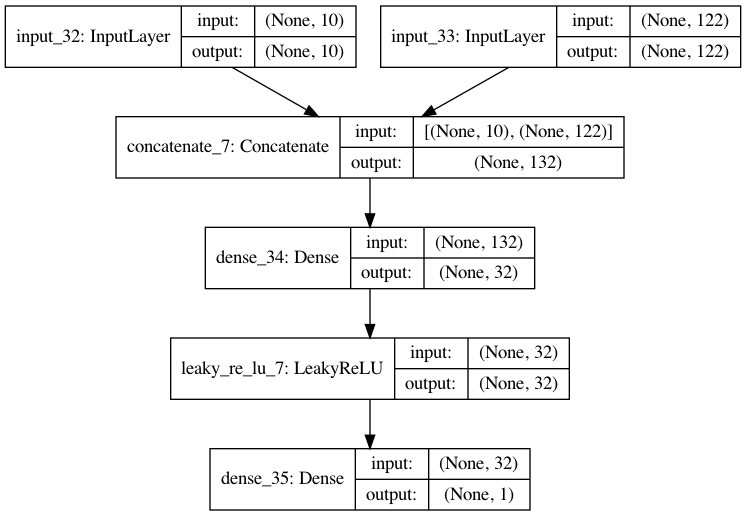

In [63]:
z = Input(shape=(latent_dim, ))
img = Input(shape=(instance_shape,))
d_in = concatenate([z, img])
model = Dense(32, kernel_initializer=initializer)(d_in)
# model = Dense(latent_dim, kernel_initializer=initializer)(d_in)
model = LeakyReLU(alpha=0.2)(model)
validity = Dense(1, activation="sigmoid")(model)
discriminator = Model([z, img], validity)
discriminator.trainable = True
discriminator.compile(loss=['binary_crossentropy'],
            optimizer=optimizer,
            metrics=['accuracy'])
discriminator.summary()
plot_model(discriminator, to_file='d_model_plot.png', show_shapes=True, show_layer_names=True)


Model: "model_19"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_34 (InputLayer)           (None, 10)           0                                            
__________________________________________________________________________________________________
input_36 (InputLayer)           (None, 122)          0                                            
__________________________________________________________________________________________________
sequential_13 (Sequential)      (None, 122)          4378        input_34[0][0]                   
__________________________________________________________________________________________________
sequential_12 (Sequential)      (None, 10)           4266        input_36[0][0]                   
___________________________________________________________________________________________

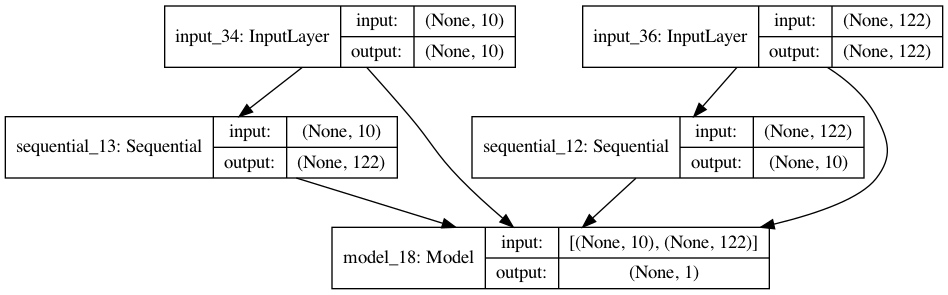

In [64]:
discriminator.trainable = False
# Generate traffic record from sampled noise
z = Input(shape=(latent_dim,))
img_ = generator(z)
# Encode traffic records to generate latent space
img = Input(shape=(instance_shape,))
z_ = encoder(img)
# Encode traffic records to generate latent space
img = Input(shape=(instance_shape,))
z_ = encoder(img)

# Latent -> img is fake, and img -> latent is valid
fake = discriminator([z, img_])
valid = discriminator([z_, img])
bigan_generator = Model([z, img], [fake, valid])
bigan_generator.compile(loss=['binary_crossentropy', 'binary_crossentropy'],
            optimizer=optimizer)
bigan_generator.summary()
plot_model(bigan_generator, to_file='biganG_model_plot.png', show_shapes=True, show_layer_names=True)

In [65]:
# X_train = X_train_scaled
# Adversarial ground truths
batch_size=64
valid = np.zeros((batch_size, 1))
fake = np.ones((batch_size, 1))
epoches = 1000
sample_interval=10

for epoch in range(epoches):
    # ---------------------
    #  Train Discriminator
    # ---------------------
    discriminator.trainable = True
    # Sample noise and generate img
    z = np.random.normal(size=(batch_size, latent_dim))
    imgs_ = generator.predict(z)

    # Select a random batch of images and encode
    idx = np.random.randint(0, X_train_scaled.shape[0], batch_size)
    imgs = X_train_scaled[idx]
    z_ = encoder.predict(imgs)

    # Train the discriminator (img -> z is valid, z -> img is fake)
    d_loss_real = discriminator.train_on_batch([z_, imgs], valid)
    d_loss_fake = discriminator.train_on_batch([z, imgs_], fake)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
    # ---------------------
    #  Train Generator
    # ---------------------

    # Train the generator (z -> img is valid and img -> z is is invalid)
    discriminator.trainable = False
    g_loss = bigan_generator.train_on_batch([z, imgs], [valid, fake])

    # Plot the progress
    if epoch % sample_interval == 0:
        print ("%d [D loss: %f, acc: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss[0]))


0 [D loss: 4.871152, acc: 13.28%] [G loss: 0.930839]
10 [D loss: 6.090159, acc: 3.91%] [G loss: 0.187292]
20 [D loss: 6.077803, acc: 1.56%] [G loss: 0.105842]
30 [D loss: 5.975478, acc: 3.91%] [G loss: 0.178323]
40 [D loss: 6.166862, acc: 5.47%] [G loss: 0.217144]
50 [D loss: 5.083453, acc: 5.47%] [G loss: 0.459626]
60 [D loss: 4.606103, acc: 3.91%] [G loss: 0.287712]
70 [D loss: 3.631577, acc: 2.34%] [G loss: 0.306067]
80 [D loss: 2.216257, acc: 39.06%] [G loss: 1.290468]
90 [D loss: 1.603079, acc: 47.66%] [G loss: 1.638290]
100 [D loss: 1.815530, acc: 21.88%] [G loss: 1.007942]
110 [D loss: 1.581016, acc: 27.34%] [G loss: 1.272284]
120 [D loss: 1.040974, acc: 40.62%] [G loss: 1.608319]
130 [D loss: 0.710341, acc: 67.19%] [G loss: 2.246157]
140 [D loss: 0.737187, acc: 70.31%] [G loss: 2.332860]
150 [D loss: 0.793325, acc: 72.66%] [G loss: 2.320720]
160 [D loss: 0.958052, acc: 49.22%] [G loss: 1.811177]
170 [D loss: 0.905340, acc: 58.59%] [G loss: 1.967615]
180 [D loss: 0.714748, acc: 

In [66]:
# bigan = BIGAN()
# bigan.train(X_train=X_train_scaled, epochs=400, batch_size=256, sample_interval=10)

In [67]:
# evaluate the discriminator
z_test_normal = encoder.predict(X_test_normal_scaled)
y_test_normal = np.zeros((X_test_normal_scaled.shape[0], 1))
discriminator.evaluate([z_test_normal, X_test_normal_scaled], y_test_normal)

9711/9711 [==============================] - 1s 57us/step


[11.717834972970678, 0.767892062664032]

In [68]:
z_test_abnormal = encoder.predict(X_test_abnormal_scaled)
y_test_abnormal = np.ones((X_test_abnormal_scaled.shape[0], 1))
discriminator.evaluate([z_test_abnormal, X_test_abnormal_scaled], y_test_abnormal)

12833/12833 [==============================] - 1s 39us/step


[0.2019612603205954, 0.9441283941268921]

In [69]:
z_test = encoder.predict(X_test_scaled)
discriminator.evaluate([z_test, X_test_scaled], y_test)

22544/22544 [==============================] - 1s 39us/step


[5.1625117113439645, 0.8682132959365845]